# Fluorescence overlays
---

This notebook demonstrates how to create fluorescence overlays using `arcadia-microscopy-tools`. We'll load a multi-channel microscopy image, preprocess the channels, and blend them together to create composite visualizations.

This page is rendered from a jupyter notebook (`docs/examples/fluorescence_overlays.ipynb`). When the docs are built, the notebook will be executed and then rendered.

### Imports

First, let's import the necessary libraries:

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from arcadia_microscopy_tools import (
    ImageOperation,
    MicroscopyImage,
    Pipeline,
    overlay_channels,
)
from arcadia_microscopy_tools.channels import BRIGHTFIELD, DAPI, FITC, TRITC
from arcadia_microscopy_tools.operations import rescale_by_percentile, subtract_background_dog

### Loading the Image

We'll load a sample PBMC (Peripheral Blood Mononuclear Cell) image that contains multiple fluorescence channels.

In [2]:
# Locate the sample ND2 file in the test data directory
sample_data_directory = Path("../../src/arcadia_microscopy_tools/tests/data")
nd2_path = next(sample_data_directory.glob("example-pbmc.nd2"))
print("ND2 file:", nd2_path)

# Load the microscopy image
image = MicroscopyImage.from_nd2_path(nd2_path)
image  # Display the image object representation

ND2 file: ../../src/arcadia_microscopy_tools/tests/data/example-pbmc.nd2


MicroscopyImage(sizes={'C': 4, 'Y': 256, 'X': 256}, channels=['BRIGHTFIELD', 'DAPI', 'FITC', 'TRITC'], intensities=[2049, 1977, 1894, ..., 778, 810, 808], dtype=uint16)

### Preprocessing Channels

Before creating overlays, we need to preprocess each channel. We'll use different pipelines for brightfield and fluorescence channels:
- **Brightfield**: Simple intensity rescaling based on percentiles
- **Fluorescence**: Background subtraction using Difference of Gaussians (DoG), followed by percentile-based rescaling

In [3]:
# Create image processing pipelines for brightfield and fluorescence channels
pipelines = {
    "brightfield": Pipeline([ImageOperation(rescale_by_percentile, percentile_range=(0.1, 99.9))]),
    "fluorescence": Pipeline(
        [
            ImageOperation(subtract_background_dog, percentile=50),
            ImageOperation(rescale_by_percentile, percentile_range=(1, 99)),
        ]
    ),
}

processed_intensities_dict = {}
for channel in image.channels:
    pipeline = (
        pipelines["fluorescence"] if channel.excitation_nm is not None else pipelines["brightfield"]
    )
    processed_intensities = image.apply_pipeline(pipeline, channel)
    processed_intensities_dict[channel] = processed_intensities

### Creating a composite fluorescence overlay from each channel

The easiest way to create a fluorescence overlay is using `overlay_channels()`. This function takes a background image and a dictionary mapping channels to their intensity arrays:

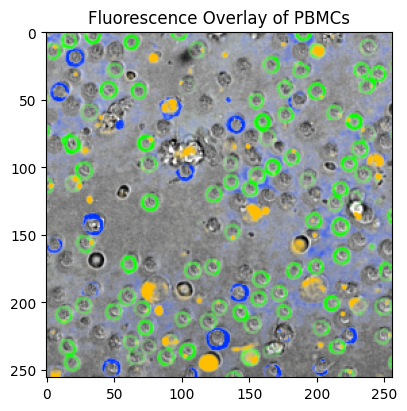

In [7]:
# Get the brightfield as background
background = processed_intensities_dict[BRIGHTFIELD]

# Get fluorescence channels
fluorescence_channels = {
    channel: processed_intensities_dict[channel]
    for channel in image.channels
    if channel.excitation_nm is not None
}

# Create the overlay
overlay = overlay_channels(
    background=background,
    channel_intensities=fluorescence_channels,
)

# Display the result
fig, ax = plt.subplots(figsize=(4, 4), layout="constrained")
_ = ax.imshow(overlay)
_ = ax.set_title("Fluorescence Overlay of PBMCs")

### Viewing Individual Channels

Let's also visualize each channel separately to understand how they contribute to the final overlay:

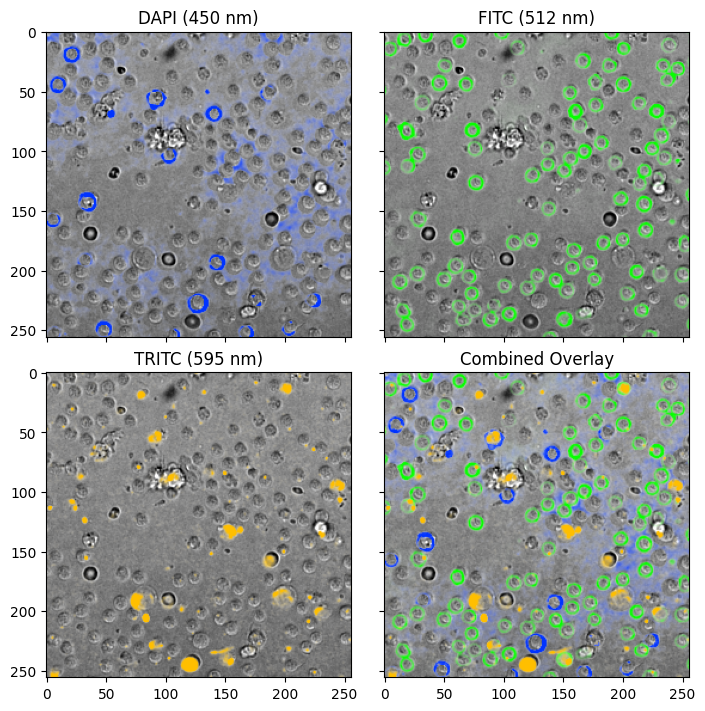

In [8]:
# Display individual channels and final overlay
fig, axes = plt.subplots(
    nrows=2,
    ncols=2,
    figsize=(7, 7),
    layout="constrained",
    sharex=True,
    sharey=True,
)

# Individual channels
for idx, channel in enumerate([DAPI, FITC, TRITC]):
    row, col = idx // 2, idx % 2
    single_channel_overlay = overlay_channels(
        background=background,
        channel_intensities={channel: processed_intensities_dict[channel]},
    )
    axes[row, col].imshow(single_channel_overlay)
    axes[row, col].set_title(f"{channel.name} ({channel.emission_nm} nm)")

# Combined overlay
_ = axes[1, 1].imshow(overlay)
_ = axes[1, 1].set_title("Combined Overlay")